# Assignment: Risk predicition of criminal re-offense



**This notebook** presents an exploration of a sub-set of data from **[SAVRY](https://www.parinc.com/Products/Pkey/390)** (Structured Assessment of Violence Risk in Youth) applied to young offenders in Catalonia. 

SAVRY is a risk assessment tool, that supports structured professional judgement. SAVRY contains 24 risk factors, in which each item (variables `V65*` to `V88*`) can have one of three values (low=0, moderate=1, high=2), for a total score between 0 and 48 points. 

+ Human score: There is also a score by a professional (variable `V56_@R1_resum_risc_global_reverse`) that can be low, moderate, or high. 
+ Recividism: In this dataset, there is information about whether people committed a new crime after the evaluation.  The variable `V115_reincidencia_2015` represents Recidivism (year 2015).
+ The variable `V60_SAVRY_total_score` contains a sum of scores in the risk items of SAVRY. This score can be seen as a baseline automatic method.

Features values can be found in ``reincidenciaJusticiaMenors.xlsx``. The description of features can be found in ``recidivismJuvenileJustice_variables_EN.pdf``. The data file we use is a subset of data obtained by the Centre d'Estudis Jurídics i Formació Especialitzada of the Catalan government and released in 2017.

The objectives of this assignment are: 
+ To compare the performance of SAVRY and ML-based methods, in terms of both performace and fairness metrics. 
+ To analyze the causes of unfairness.
+ To explore a mitigation strategy.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Exploration

In [68]:
FILENAME_DATASET = 'reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)
df.head()

id V1_sexe V2_estranger V3_nacionalitat V4_nacionalitat_agrupat  \
0   691    Home     Espanyol         Espanya                     NaN   
1   956    Dona     Espanyol         Espanya                     NaN   
2  2560    Home    Estranger          Marroc                  Magrib   
3  2018    Home    Estranger          Marroc                  Magrib   
4  1650    Home     Espanyol         Espanya                     NaN   

  V5_edat_fet_agrupat V6_provincia  V7_comarca  V8_edat_fet  \
0        14 i 15 anys       Lleida      Segrià         15.0   
1        14 i 15 anys    Barcelona  Barcelonès         14.0   
2        14 i 15 anys    Barcelona       Anoia         15.0   
3        14 i 15 anys       Girona     Gironès         14.0   
4        16 i 17 anys    Tarragona  Tarragonès         17.0   

   V9_edat_final_programa  ...      V123_rein_fet_agrupat_2013  \
0                      17  ...  Contra la propietat no violent   
1                      15  ...  Contra la propietat no violent   
2                      16  ...                          Altres   
3                      15  ...                          Altres   
4                      20  ...                          Altres   

   V124_rein_fet_violencia_2013 V125_rein_fet_tipus_2013  \
0                    No violent                  Delicte   
1                    No violent                  Delicte   
2                    No violent                  Delicte   
3                    No violent                  Delicte   
4                    No violent                  Delicte   

  V126_primera_reincidencia_2013                     V127_rein_programa_2013  \
0                          Presó                           SIPC - Preventiva   
1               Justícia juvenil                 Assessorament tècnic menors   
2               Justícia juvenil      Realització de tasques socioeducatives   
3               Justícia juvenil     Permanència de cap de setmana en centre   
4                            MPA  MPA - Treballs en benefici de la comunitat   

  V128_rein_programa_agrupat_2013 V129_on_reincidencia_2013  \
0                           Presó               Només Presó   
1                             ATM                  Només JJ   
2                       Altres MO  Justícia juvenil i presó   
3                     Internament                  Només JJ   
4                             TBC                 Només MPA   

  V130_nombre_rein_agrupat_2013 V131_severitat_puntuacio_2013  \
0           2 o 3 reincidències                           2.0   
1           2 o 3 reincidències                           1.0   
2        Més de 3 reincidències                           2.0   
3        Més de 3 reincidències                           3.0   
4                1 reincidència                           1.0   

  V132_REINCIDENCIA_2013  
0                     Sí  
1                     Sí  
2                     Sí  
3                     Sí  
4                     Sí  

[5 rows x 142 columns]

In [69]:
for k,i in enumerate(list(df.columns)):
    print(k,i)

0 id
1 V1_sexe
2 V2_estranger
3 V3_nacionalitat
4 V4_nacionalitat_agrupat
5 V5_edat_fet_agrupat
6 V6_provincia
7 V7_comarca
8 V8_edat_fet
9 V9_edat_final_programa
10 V10_data_naixement
11 xxxxxxxx_FETS
12 V11_antecedents
13 V12_nombre_ante_agrupat
14 V13_nombre_fets_agrupat
15 V14_fet
16 V15_fet_agrupat
17 V16_fet_violencia
18 V17_fet_tipus
19 V19_fets_desagrupats
20 V20_nombre_antecedents
21 V21_fet_nombre
22 V22_data_fet
23 xxxxxxxx_PROGRAMA
24 V23_territori
25 V24_programa
26 V25_programa_mesura
27 V26_mesures
28 V27_durada_programa_agrupat
29 V28_temps_inici
30 V29_durada_programa
31 V30_data_inici_programa
32 V31_data_fi_programa
33 xxxxxxxxxxxxxx_MRM
34 V32_MRM_resultat
35 V33_MRM_participacio_victima
36 V34_MRM_tipus
37 V35_MRM_forma
38 V36_MRM_negatiu
39 V37_MRM_conciliacio_victimaexlus
40 V38_MRM_reparacio_economica
41 V39_MRM_reparacio_noeconomica
42 V40_MRM_reparacio_comunitaria
43 V41_MRM_participacio_trobada
44 V42_MRM_participacio_notrobada
45 V43_MRM_iniciativa_parts
46 

In [70]:
# data cleaning

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"]>48].index)

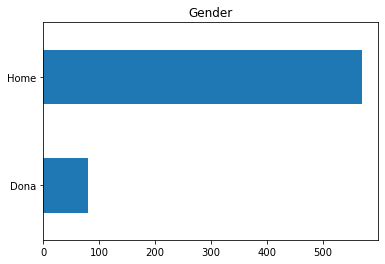

In [71]:
# data distribution by gender

_ = df['V1_sexe'].value_counts(ascending=True).plot(kind='barh', title='Gender')

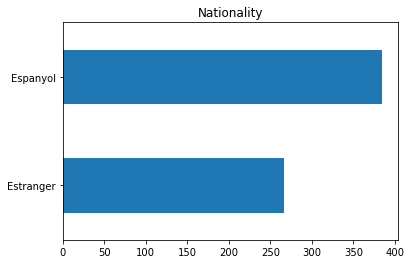

In [72]:
# data distribution by nationality

_ = df['V2_estranger'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

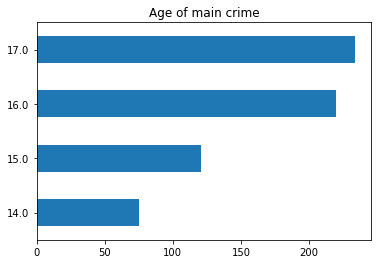

In [73]:
# data distribution by age

_ = df['V8_edat_fet'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

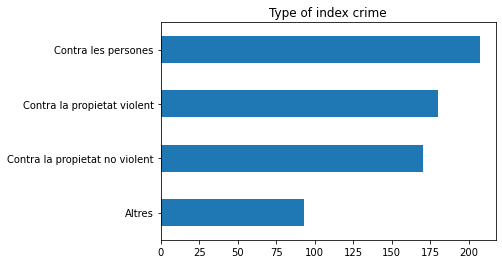

In [74]:
# data distribution by type of index crime

_ = df['V15_fet_agrupat'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

## SAVRY model (human assessment)

The column `V56_@R1_resum_risc_global_reverse` is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but **applying his/her own judgment independently of the obtained score**.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

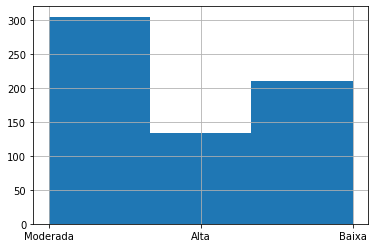

In [75]:
# human score distribution

hist = df['V56_@R1_resum_risc_global_reverse'].hist(bins=3)

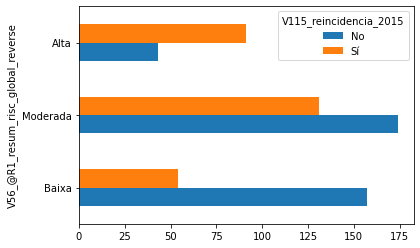

In [76]:
# human score distribution | recividism

human_ctable = pd.crosstab(df['V56_@R1_resum_risc_global_reverse'], df['V115_reincidencia_2015'])
human_ctable = human_ctable.reindex(index=["Baixa", "Moderada", "Alta"])
_ = human_ctable.plot(kind='barh')

In [77]:
# recividism rate per score

human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype='float')
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Sí"] / (row["Sí"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

V115_reincidencia_2015              No   Sí  recidivism_rate
V56_@R1_resum_risc_global_reverse                           
Baixa                              157   54         0.255924
Moderada                           174  131         0.429508
Alta                                43   91         0.679104

### Baseline model

Our baseline prediction can be based on the column `V60_SAVRY_total_score`, which contains a sum of scores in the risk items of SAVRY. The max value of this sum is 40.

In [78]:
scores_recidivists = df[df["V115_reincidencia_2015"]=='Sí']["V60_SAVRY_total_score"].values
scores_non_recidivists = df[df["V115_reincidencia_2015"]=='No']["V60_SAVRY_total_score"].values

In [79]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

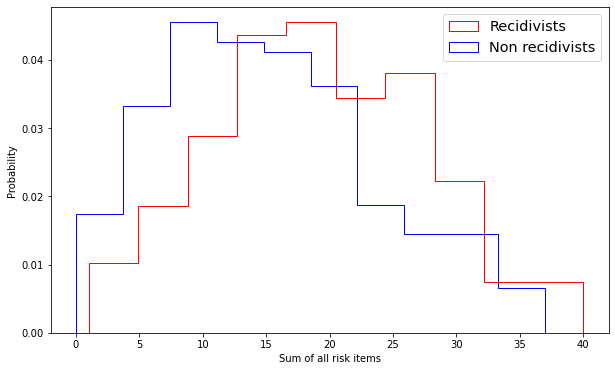

In [80]:
## baselin score distribution

compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [81]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

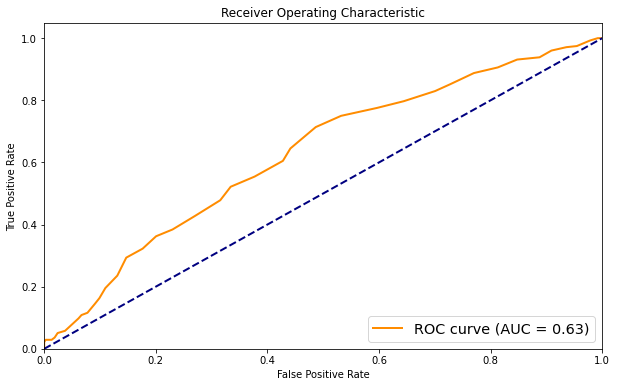

In [82]:
# Evaluation (ROC curve) of the baseline prediction

_ = draw_roc_curve(df["V115_reincidencia_2015"].values, df["V60_SAVRY_total_score"].values)

## Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [83]:
train, test = train_test_split(df, test_size=0.33)

### Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [84]:
risk_factor_columns = list(df.columns)[70:94]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["V115_reincidencia_2015"]

In [85]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [86]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Sí']
pred24_non_recidivists = pred24_y[test_y == 'No']

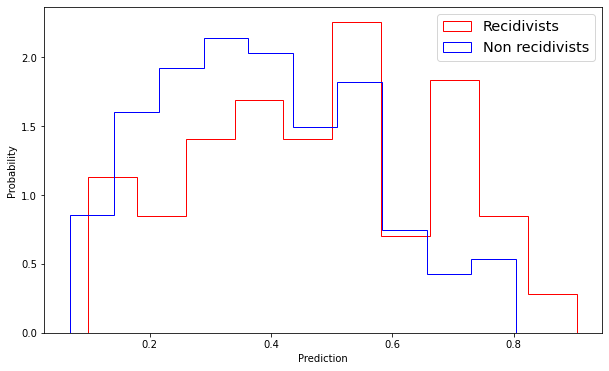

In [87]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

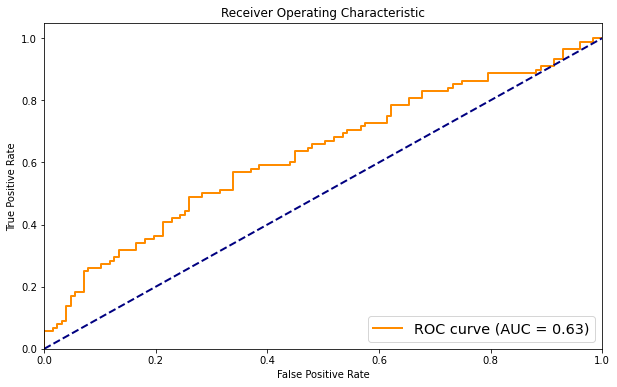

In [88]:
_ = draw_roc_curve(test_y, pred24_y)

### Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [89]:
demographic_columns = ["V1_sexe", 
                       "V2_estranger", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents",
                       "V15_fet_agrupat", 
                       "V16_fet_violencia"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["V115_reincidencia_2015"]

test_X =  pd.get_dummies(test[demographic_columns])
test_y = test["V115_reincidencia_2015"]

In [90]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [91]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Sí']
predPH_non_recidivists = predPH_y[test_y == 'No']

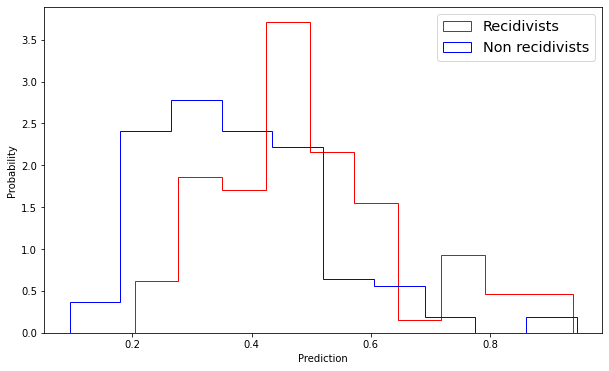

In [92]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

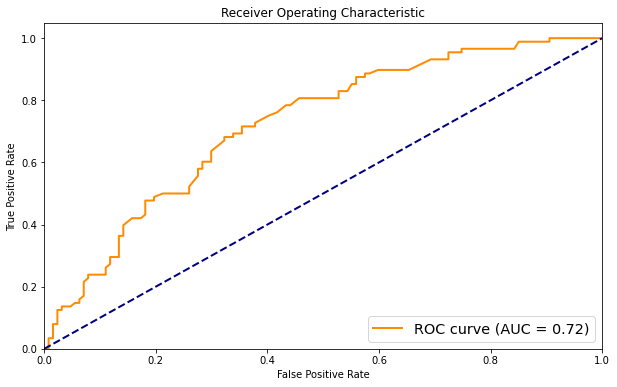

In [93]:
_ = draw_roc_curve(test_y, predPH_y)

### Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [94]:
protective_factor_columns = ["V89_@P1_impicacio_prosocial", 
                             "V90_@P2_suport_social_fort",
                             "V91_@P3_forta_vinculacio_adult_prosocial", 
                             "V92_@P4_actitud_positiva_intervencions_autoritat",
                             "V93_@P5_fort_compromis_escola_treball", 
                             "V94_@P6_perseverança_tret_personalitat"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [95]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [96]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Sí']
predALL_non_recidivists = predALL_y[test_y == 'No']

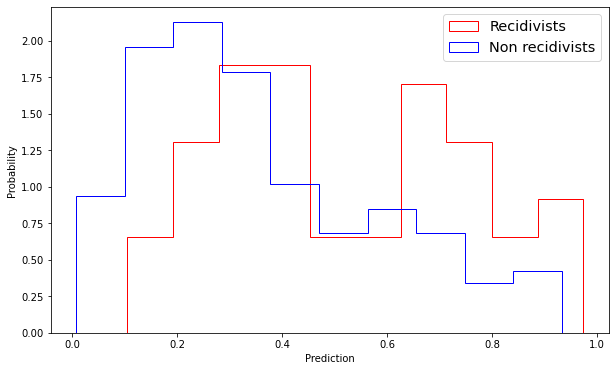

In [97]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

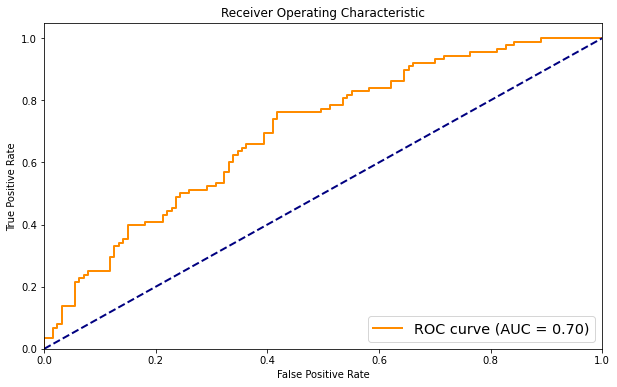

In [98]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism and fairness
We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a higher rate than nationals.

In [99]:
recidivism_by_gender = pd.crosstab(df["V115_reincidencia_2015"], df["V1_sexe"])
recidivism_by_gender['Dona'] = recidivism_by_gender['Dona'] / recidivism_by_gender['Dona'].sum()
recidivism_by_gender['Home'] = recidivism_by_gender['Home'] / recidivism_by_gender['Home'].sum()
recidivism_by_gender

V1_sexe                     Dona      Home
V115_reincidencia_2015                    
No                      0.759494  0.549912
Sí                      0.240506  0.450088

In [100]:
recidivism_by_nationality = pd.crosstab(df["V115_reincidencia_2015"], df["V2_estranger"])
recidivism_by_nationality['Espanyol'] = recidivism_by_nationality['Espanyol'] / recidivism_by_nationality['Espanyol'].sum()
recidivism_by_nationality['Estranger'] = recidivism_by_nationality['Estranger'] / recidivism_by_nationality['Estranger'].sum()
recidivism_by_nationality

V2_estranger            Espanyol  Estranger
V115_reincidencia_2015                     
No                      0.632812   0.492481
Sí                      0.367188   0.507519

# Fairness as **equality of error rates**

We can look at fairness as **equality of error rates**.

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [101]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
non_recidivists_expert_by_gender

V1_sexe                                Dona      Home
V56_@R1_resum_risc_global_reverse                    
Alta                               0.116667  0.114650
Baixa                              0.433333  0.417197
Moderada                           0.450000  0.468153

In [102]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
non_recidivists_expert_by_nationality

V2_estranger                       Espanyol  Estranger
V56_@R1_resum_risc_global_reverse                     
Alta                               0.106996   0.129771
Baixa                              0.423868   0.412214
Moderada                           0.469136   0.458015

## Overall SAVRY score and fairness

In [103]:
scores_men_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                      (df["V1_sexe"]=='Home')]["V60_SAVRY_total_score"].values
scores_women_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V1_sexe"]=='Dona')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of men non-recidivist: %.2f" %
      (scores_men_non_recidivists.sum() / len(scores_men_non_recidivists)))
       
print("Average SAVRY score of women non-recidivist: %.2f" % 
      (scores_women_non_recidivists.sum() / len(scores_women_non_recidivists)))

Average SAVRY score of men non-recidivist: 15.38
Average SAVRY score of women non-recidivist: 15.67


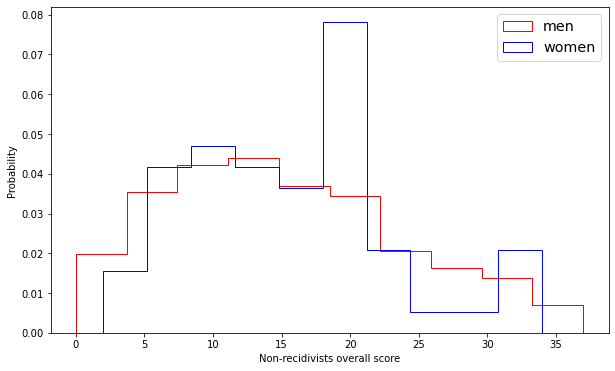

In [104]:
compare_histograms(scores_men_non_recidivists, scores_women_non_recidivists,
                   "Non-recidivists overall score",
                   label1="men", label2="women")

In [105]:
scores_nationals_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V2_estranger"]=='Espanyol')]["V60_SAVRY_total_score"].values
scores_foreigners_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V2_estranger"]=='Estranger')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 18.89
Average SAVRY score of foreigner non-recidivist: 16.51


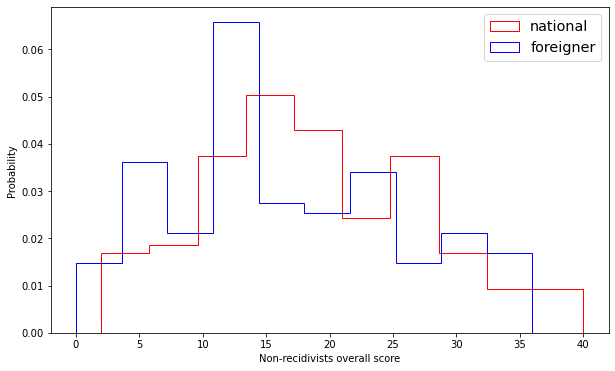

In [106]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="national", label2="foreigner")

## Fairness using ML score

In [107]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.42
Average predicted probability of women non-recidivist: 0.22


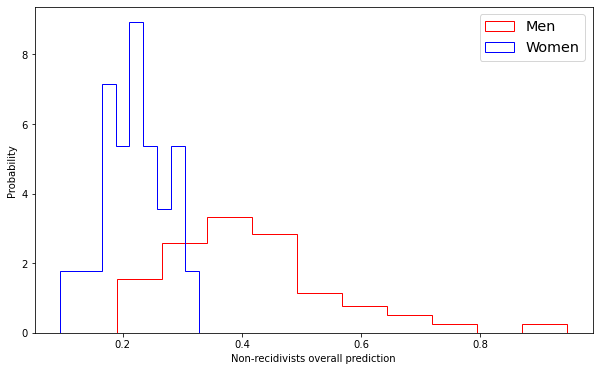

In [108]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

In [109]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.33
Average predicted probability of foreigner non-recidivist: 0.46


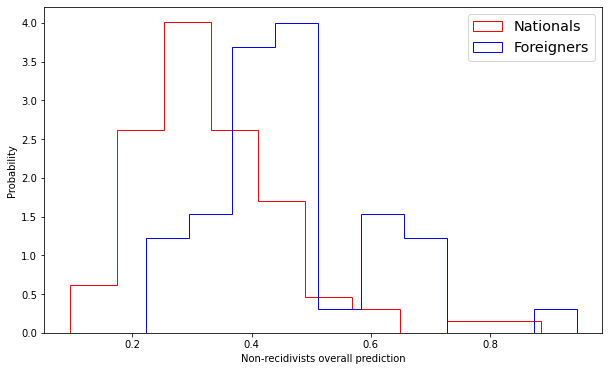

In [110]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Exercise 1

1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 
2. Check if they satisfy the proposed fairness criteria. 
3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

### Questions (justify your answers)

1. Is there a method that can achieve better predictive power than human experts? 


2. Is this method better than human experts in terms of fairness?


3. Which is the most suited fairness criterium for this problem? Why?


4. What are your conclusion about the use of a ML model to predict recividism?



#### 1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 

In [111]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
predictions = []

##### 1.1 KNeighborsClassifier

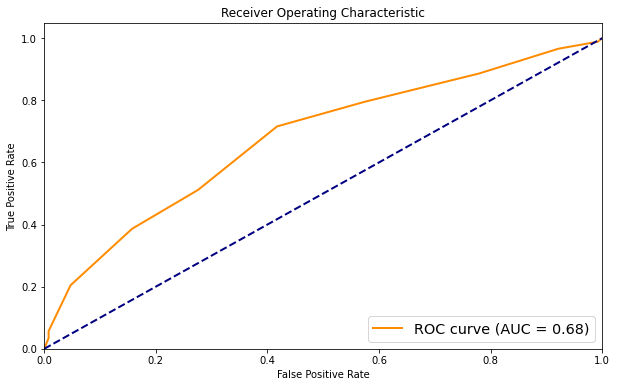

In [112]:
classifier_kn = KNeighborsClassifier(n_neighbors = 12, metric = "minkowski", p = 2)
classifier_kn.fit(train_X, train_y)
predALL_y_kn = classifier_kn.predict_proba(test_X)[:,1]
_ = draw_roc_curve(test_y, predALL_y_kn)
predictions.append(predALL_y_kn)

##### 1.2 SVM

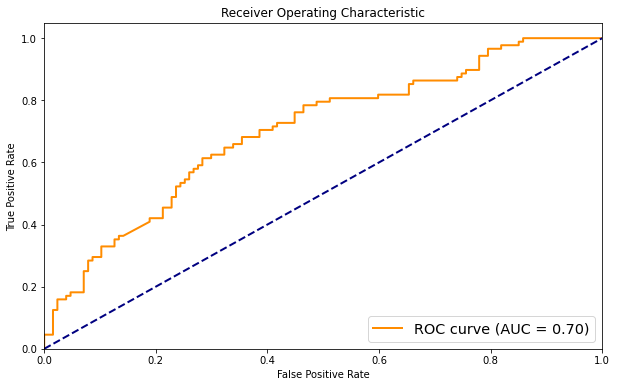

In [113]:
classifier_svc = SVC(kernel = "linear", random_state = 0, probability=True)
classifier_svc.fit(train_X, train_y)
predALL_y_svc = classifier_svc.predict_proba(test_X)[:,1]
_ = draw_roc_curve(test_y, predALL_y_svc)
predictions.append(predALL_y_svc)

##### 1.3 Kernel SVM

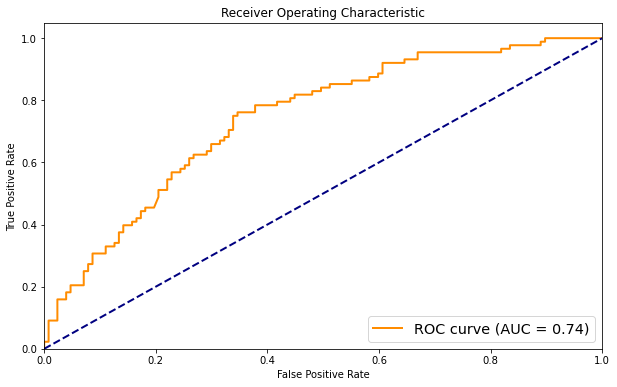

In [114]:
classifier_svc_rb = SVC(kernel = "rbf", random_state = 0, probability=True)
classifier_svc_rb.fit(train_X, train_y)
predALL_y_svc_rb = classifier_svc_rb.predict_proba(test_X)[:,1]
_ = draw_roc_curve(test_y, predALL_y_svc_rb)
predictions.append(predALL_y_svc_rb)

##### 1.4 Gaussian Naive Bayes (GaussianNB).

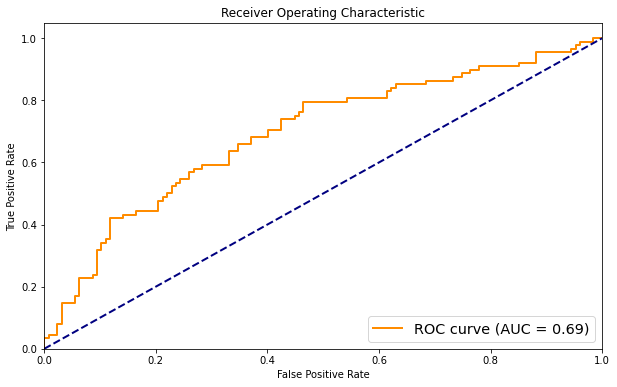

In [115]:
classifier_nb = GaussianNB()
classifier_nb.fit(train_X, train_y)
predALL_y_nb = classifier_nb.predict_proba(test_X)[:,1]
_ = draw_roc_curve(test_y, predALL_y_nb)
predictions.append(predALL_y_nb)

##### 1.5 DecisionTree

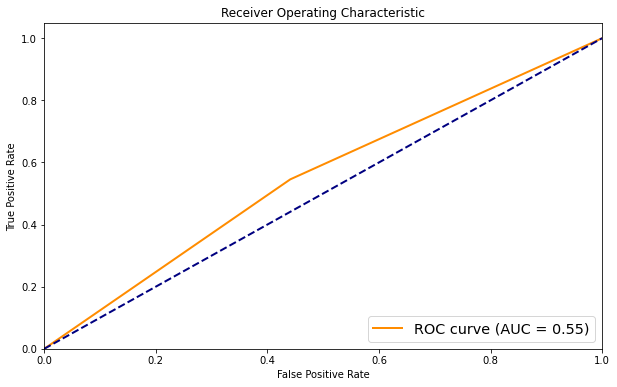

In [116]:
classifier_dtc = DecisionTreeClassifier(criterion = "gini", random_state = 0)
classifier_dtc.fit(train_X, train_y)
predALL_y_dtc = classifier_dtc.predict_proba(test_X)[:,1]
_ = draw_roc_curve(test_y, predALL_y_dtc)
predictions.append(predALL_y_dtc)

##### 1.6 RandomForest

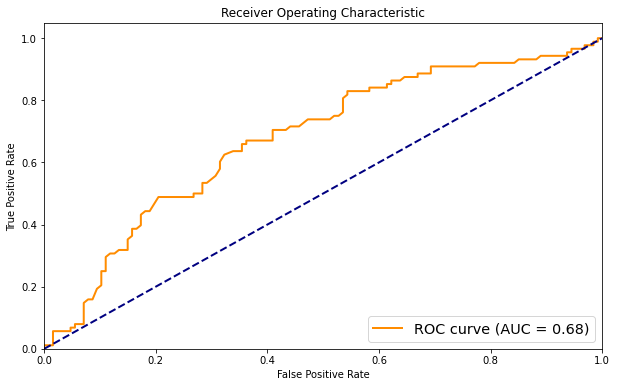

In [117]:
classifier_rfc = RandomForestClassifier(n_estimators = 400, criterion = "entropy", random_state = 0)
classifier_rfc.fit(train_X, train_y)
predALL_y_rfc = classifier_rfc.predict_proba(test_X)[:,1]
_ = draw_roc_curve(test_y, predALL_y_rfc)
predictions.append(predALL_y_rfc)

### ANSWER:
In some cases, I improve the baseline and the other cases I made it worse. The average among the best models is between 0.71-0.72 giving a maximum of 0.75. I think it can't get any better than that. The worst models could be improved by modifying hyperparameters.

## 2. Check if they satisfy the proposed fairness criteria.

Same code that above, but with all models but adding differences by sex and origen

In [118]:
names = ["KN", "SVM", "KERNEL_SVM", "GAUSSIANNB", "DECISIONTREE", "RANDOM_FOREST"]
avgMan = []
avgWom = []
avgNat = []
avgFor = []

for pred in predictions:
    predALL_y = model.predict_proba(test_X)[:,1]
    predPH_men_non_recidivists = pred[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
    predPH_women_non_recidivists = pred[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

    avgMan.append(predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists))

    avgWom.append(predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists))

    predPH_nationals_non_recidivists = pred[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_foreigners_non_recidivists = pred[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

    avgNat.append(predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists))

    avgFor.append(predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists))

modelFair =  pd.DataFrame(list(zip(names,avgMan,avgWom,avgNat,avgFor)),columns=["Model Name",
                                                                               "Avg. Prob. Man",
                                                                                "Avg. Prob. Woman",
                                                                               "Avg. Prob. National",
                                                                               "Avg. Prob. Foreigner"])

modelFair["Diff Sex"] = abs(modelFair["Avg. Prob. Man"]-modelFair["Avg. Prob. Woman"])
modelFair["Diff Origen"] = abs(modelFair["Avg. Prob. National"]-modelFair["Avg. Prob. Foreigner"])

In [119]:
modelFair.sort_values("Diff Sex",ascending=False)

Model Name  Avg. Prob. Man  Avg. Prob. Woman  Avg. Prob. National  \
3     GAUSSIANNB        0.372952          0.076008             0.278930   
4   DECISIONTREE        0.466019          0.333333             0.402439   
2     KERNEL_SVM        0.400214          0.327543             0.369456   
1            SVM        0.427087          0.361897             0.409183   
5  RANDOM_FOREST        0.403544          0.345625             0.372805   
0             KN        0.353560          0.326389             0.331301   

   Avg. Prob. Foreigner  Diff Sex  Diff Origen  
3              0.385912  0.296944     0.106983  
4              0.511111  0.132686     0.108672  
2              0.417505  0.072671     0.048049  
1              0.424945  0.065191     0.015762  
5              0.428667  0.057919     0.055862  
0              0.379630  0.027171     0.048329

In [120]:
modelFair.sort_values("Diff Origen",ascending=False)

Model Name  Avg. Prob. Man  Avg. Prob. Woman  Avg. Prob. National  \
4   DECISIONTREE        0.466019          0.333333             0.402439   
3     GAUSSIANNB        0.372952          0.076008             0.278930   
5  RANDOM_FOREST        0.403544          0.345625             0.372805   
0             KN        0.353560          0.326389             0.331301   
2     KERNEL_SVM        0.400214          0.327543             0.369456   
1            SVM        0.427087          0.361897             0.409183   

   Avg. Prob. Foreigner  Diff Sex  Diff Origen  
4              0.511111  0.132686     0.108672  
3              0.385912  0.296944     0.106983  
5              0.428667  0.057919     0.055862  
0              0.379630  0.027171     0.048329  
2              0.417505  0.072671     0.048049  
1              0.424945  0.065191     0.015762

##### The major difference is with the best models in AUC Score!

## 3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity.

##### Based on Accuracy-based fairness

![title](img/img.png)

In [121]:
def cm_custom(test_X,test_y,preds):
    resultDF = pd.DataFrame()
    resultDF["Gender"] = ["Home" if i == 1 else "Dona" for i in test_X["V1_sexe_Home"]]
    resultDF["Nationality"] = ["National" if i == 1 else "Foreigner" for i in test_X["V2_estranger_Espanyol"]]
    resultDF["True"] = ["Si" if i == "Sí" else "No" for i in test_y]
    resultDF["Predict"] = ["Si" if i == 1 else "No" for i in np.round(preds)]
    return resultDF

In [122]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

for i, pred in enumerate(predictions):
    cm = pd.DataFrame(confusion_matrix([1 if i == "Sí" else 0 for i in test_y], np.round(pred)),columns=["Actual Positive","Actual Negative"])
    cm.index = ["Pred Positive","Pred Negative"]
    acc = accuracy_score([1 if i == "Sí" else 0 for i in test_y], np.round(pred))
    f1 = f1_score([1 if i == "Sí" else 0 for i in test_y], np.round(pred),average="macro")
    precis = precision_score([1 if i == "Sí" else 0 for i in test_y], np.round(pred))
    recall = recall_score([1 if i == "Sí" else 0 for i in test_y], np.round(pred))
    display(names[i])
    display(cm)
    print("Accuracy: ", acc)
    print("F1: ", f1)
    print("Precision: ", precis)
    print("Recall: ", recall)
    print("\n")
    df_cm = cm_custom(test_X,test_y,pred)
    display(df_cm.pivot_table(index=["Predict"], columns=["Gender","True"], aggfunc='size',fill_value=0))
    display(df_cm.pivot_table(index=["Predict"], columns=["Nationality","True"], aggfunc='size',fill_value=0))

'KN'

Actual Positive  Actual Negative
Pred Positive              107               20
Pred Negative               54               34

Accuracy:  0.6558139534883721
F1:  0.6109643974960877
Precision:  0.6296296296296297
Recall:  0.38636363636363635




Gender  Dona    Home    
True      No Si   No  Si
Predict                 
No        23  2   84  52
Si         1  3   19  31

Nationality Foreigner     National    
True               No  Si       No  Si
Predict                               
No                 35  24       72  30
Si                 10  20       10  14

'SVM'

Actual Positive  Actual Negative
Pred Positive              109               18
Pred Negative               56               32

Accuracy:  0.6558139534883721
F1:  0.6051717292038913
Precision:  0.64
Recall:  0.36363636363636365




Gender  Dona    Home    
True      No Si   No  Si
Predict                 
No        21  4   88  52
Si         3  1   15  31

Nationality Foreigner     National    
True               No  Si       No  Si
Predict                               
No                 37  22       72  34
Si                  8  22       10  10

'KERNEL_SVM'

Actual Positive  Actual Negative
Pred Positive              102               25
Pred Negative               48               40

Accuracy:  0.6604651162790698
F1:  0.62966895542814
Precision:  0.6153846153846154
Recall:  0.45454545454545453




Gender  Dona    Home    
True      No Si   No  Si
Predict                 
No        24  2   78  46
Si         0  3   25  37

Nationality Foreigner     National    
True               No  Si       No  Si
Predict                               
No                 32  20       70  28
Si                 13  24       12  16

'GAUSSIANNB'

Actual Positive  Actual Negative
Pred Positive               85               42
Pred Negative               33               55

Accuracy:  0.6511627906976745
F1:  0.6442360728075014
Precision:  0.5670103092783505
Recall:  0.625




Gender  Dona    Home    
True      No Si   No  Si
Predict                 
No        23  2   62  31
Si         1  3   41  52

Nationality Foreigner     National    
True               No  Si       No  Si
Predict                               
No                 26  10       59  23
Si                 19  34       23  21

'DECISIONTREE'

Actual Positive  Actual Negative
Pred Positive               71               56
Pred Negative               40               48

Accuracy:  0.5534883720930233
F1:  0.5483193277310925
Precision:  0.46153846153846156
Recall:  0.5454545454545454




Gender  Dona    Home    
True      No Si   No  Si
Predict                 
No        16  1   55  39
Si         8  4   48  44

Nationality Foreigner     National    
True               No  Si       No  Si
Predict                               
No                 22  17       49  23
Si                 23  27       33  21

'RANDOM_FOREST'

Actual Positive  Actual Negative
Pred Positive               94               33
Pred Negative               45               43

Accuracy:  0.6372093023255814
F1:  0.615578580597836
Precision:  0.5657894736842105
Recall:  0.48863636363636365




Gender  Dona    Home    
True      No Si   No  Si
Predict                 
No        20  1   74  44
Si         4  4   29  39

Nationality Foreigner     National    
True               No  Si       No  Si
Predict                               
No                 28  15       66  30
Si                 17  29       16  14

#### 1. Is there a method that can achieve better predictive power than human experts? 

Today, I don't think it is possible to replace a human with machine learning algorithms. Fundamentally, I believe that ML can enhance the human rather than replace it, for example, because a human is not able to process so much information about someone at the same time. In the same way, even the decisions that a human makes do not even consider whether or not they are good decisions. People in very similar situations can make different decisions based on their type. In addition, I believe the data is important if it is balanced, biased, etc.


#### 2. Is this method better than human experts in terms of fairness?
The decision of the experts is better than the my models. Perhaps there is more than just the data to make a decision.

#### 3. Which is the most suited fairness criterium for this problem? Why?

The problem collects important data such as gender, low-marginal, etc.

The truth is that these are data that the algorithm can bias as racist, sexist for socio-economic reasons so it is important to have a better balanced dataset. 

If we talk about the second analysis, I think the best one is Equalized Odds because of the results shown.

#### 4. What are your conclusion about the use of a ML model to predict recividism?
You can have a model with a fairly low error rate but be completely biased. For example, predict a person's age, but not be able to distinguish ethnicity, geneder, expressions, etc.

# Exercise 2

We have seen that the bias in the data with respect to the protected features (sex, nationality) yields disparity between groups. To analyze the influence of data bias with respect to the protected features we can perform a comparison of the baseline, unrestricted data settings with one mitigation method that addresses these issues: equalized base rates (EBR). Differences in predictive performance, group fairness and the set of features, which are important for prediction, provide further insights in the role that these conditions play with respect to group fairness.

EBR assumes the following stratified oversampling procedure. Considering the input features $x$ and the outcomes $y$, a protected feature $f'$ has $I$ possible values corresponding to different groups: $\{g_1,…,g_I\}$, comprising a reference group $g_{ref}$. For each group $g_i$, different to the reference group, we compute the number of positive or negative condition samples $|S_i|$ we need to add to the training data, where $|S_i|$ is the absolute value of $S_i = P(x(f')=g_i)(P(y|x(f')=g_i) - P(y|x(f')=g_{ref}))$. 

If $S_i$ is negative then we add to the data $|S_i|$ negative condition samples $P(y=0| P(x(f')=g_i)$, while for $S_i$ positive we add $|S_i|$ positive condition samples $P(y=1| P(x(f')=g_i)$ of group $g_i$. This procedure yields equal base rates between the group $g_i$ and the reference group $g_{ref}$, namely $P(x(f')=g_i) = P(x(f')=g_{ref})$.

### Questions (justify your answers)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

In [123]:
train_X_mod = train_X.copy()

g_ref = train_X_mod[train_X_mod.V1_sexe_Dona == 0][train_X_mod.V2_estranger_Estranger == 0]
g_ref_r = train_y[g_ref.index].value_counts()["Sí"]
g_ref_non = train_y[g_ref.index].value_counts()["No"]

print("Target samples: ", len(g_ref))
print("Recidivism: ", g_ref_r)
print("Target non-recidivism rate: ", g_ref_non)


Target samples:  219
Recidivism:  86
Target non-recidivism rate:  133


Boolean Series key will be reindexed to match DataFrame index.


I think that this is not enough. Data augmentation is good if you want to increase the number of samples, but it is not enough if you want to increase the number of samples to be equal to the number of samples of the reference group, because you obtain repetitive samples if you have small groups, so the model could be memorize and not learn the difference between the groups so it could be biased.

# Exercise 3

In order to see which fearures are important for different predictive models we can use ML explainability models. 

Apply ML explainability models to the (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). 

### Questions

1. Which are the top ten most important features of each model?

2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

In [124]:
from sklearn.preprocessing import label_binarize

train_HRisk = train["V56_@R1_resum_risc_global_reverse"].replace('Baixa',0).replace('Moderada',1).replace('Alta',2)
test_HRisk = test["V56_@R1_resum_risc_global_reverse"].replace('Baixa',0).replace('Moderada',1).replace('Alta',2)
train_y_2 = label_binarize(train_HRisk, classes=[0, 1, 2])
test_y_2 = label_binarize(test_HRisk, classes=[0, 1, 2])

In [125]:
import shap
import eli5.sklearn
from sklearn.multiclass import OneVsRestClassifier
shap.initjs()

In [126]:
def plot_multilabel(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure()
    lw = 2
    plt.plot(
        fpr[2],
        tpr[2],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[2],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Roc Curve")
    plt.legend(loc="lower right")
    plt.show()

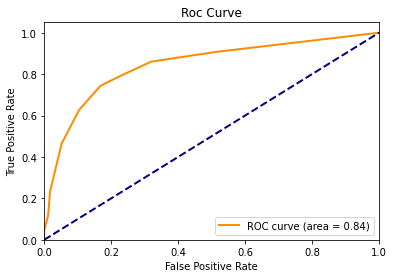

Permutation explainer: 436it [02:12,  3.05it/s]                         


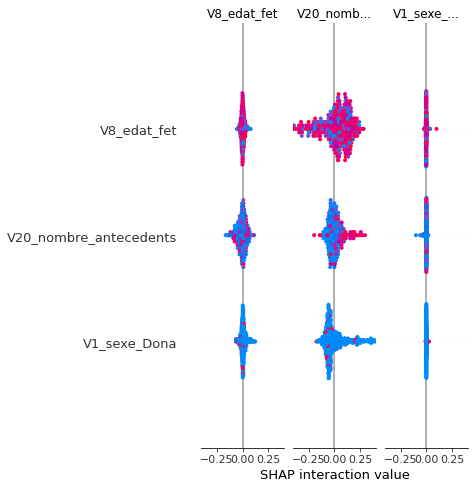

In [127]:
classifier_kn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 12, metric = "minkowski", p = 2))
model = classifier_kn.fit(train_X, train_y_2)
predALL_y_kn = classifier_kn.predict_proba(test_X)
_ = plot_multilabel(test_y_2, predALL_y_kn)

explainer = shap.Explainer(model.predict_proba, train_X)
shap_values = explainer(train_X)
shap.initjs()
shap.summary_plot(shap_values.values, train_X)

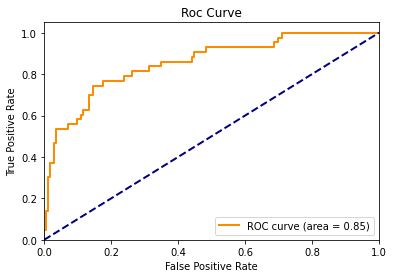

Permutation explainer: 436it [01:27,  4.41it/s]                         


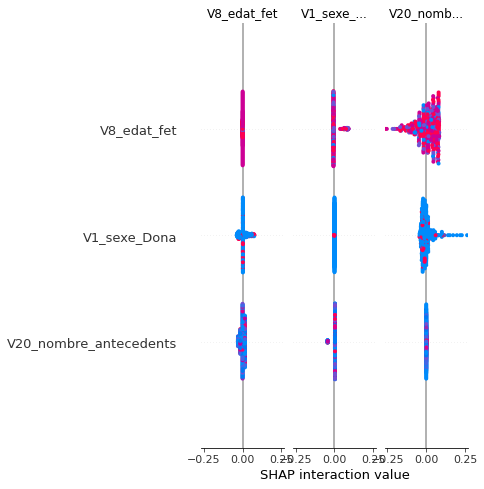

In [128]:
classifier_svc = OneVsRestClassifier(SVC(kernel = "linear", random_state = 0, probability=True))
model = classifier_svc.fit(train_X, train_y_2)
predALL_y_svc = classifier_svc.predict_proba(test_X)
_ = plot_multilabel(test_y_2, predALL_y_svc)

explainer = shap.Explainer(model.predict_proba, train_X, algorithm = "auto")
shap_values = explainer(train_X)
shap.initjs()
shap.summary_plot(shap_values.values, train_X)

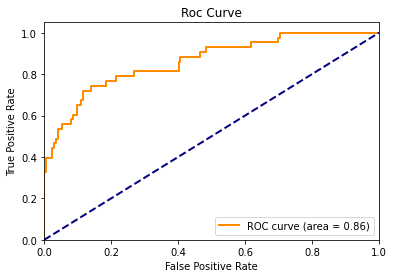

Permutation explainer: 436it [04:49,  1.45it/s]                         


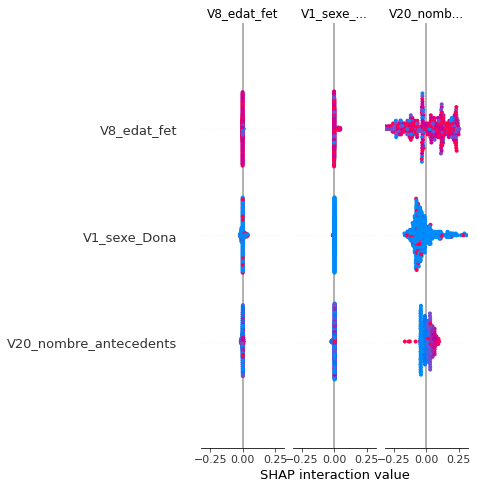

In [129]:
classifier_svc_rb = OneVsRestClassifier(SVC(kernel = "rbf", random_state = 0, probability=True))
model = classifier_svc_rb.fit(train_X, train_y_2)
predALL_y_svc_rb = classifier_svc_rb.predict_proba(test_X)
_ = plot_multilabel(test_y_2, predALL_y_svc_rb)

explainer = shap.Explainer(model.predict_proba, train_X, algorithm = "auto")
shap_values = explainer(train_X)
shap.initjs()
shap.summary_plot(shap_values.values, train_X)

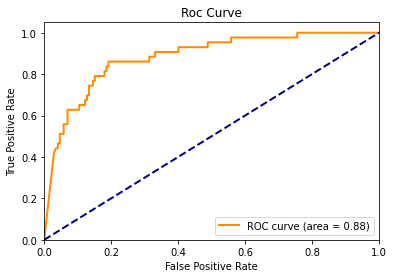

Permutation explainer: 436it [00:14,  9.29it/s]                         


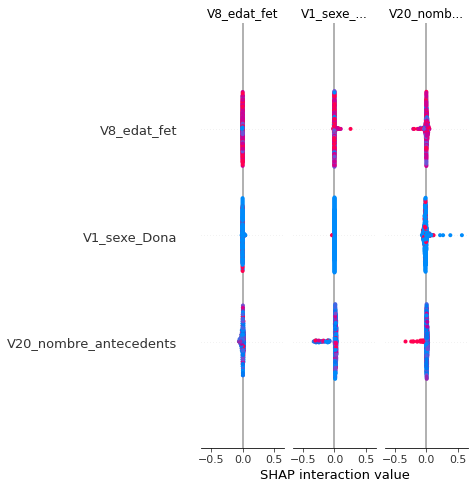

In [130]:
classifier_nb = OneVsRestClassifier(GaussianNB())
model = classifier_nb.fit(train_X, train_y_2)
predALL_y_nb = classifier_nb.predict_proba(test_X)
_ = plot_multilabel(test_y_2, predALL_y_nb)

explainer = shap.Explainer(model.predict_proba, train_X,algorithm = "auto")
shap_values = explainer(train_X)
shap.initjs()
shap.summary_plot(shap_values.values, train_X)

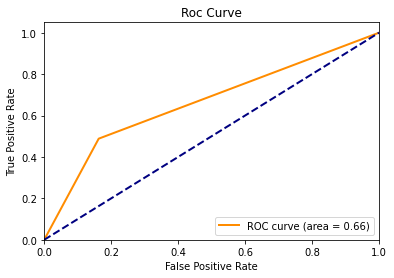

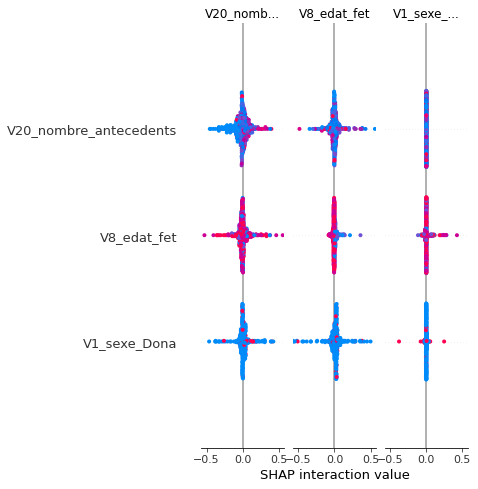

In [131]:
classifier_dtc = OneVsRestClassifier(DecisionTreeClassifier(criterion = "gini", random_state = 0))
model = classifier_dtc.fit(train_X, train_y_2)
predALL_y_dtc = classifier_dtc.predict_proba(test_X)
_ = plot_multilabel(test_y_2, predALL_y_dtc)

explainer = shap.Explainer(model.predict_proba, train_X, algorithm = "auto")
shap_values = explainer(train_X)
shap.initjs()
shap.summary_plot(shap_values.values, train_X)

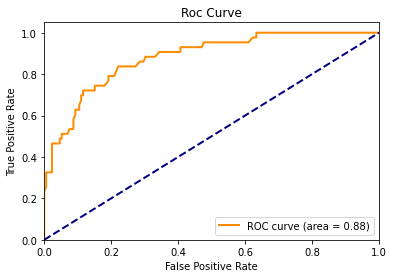

Permutation explainer: 436it [06:58,  1.02it/s]                         


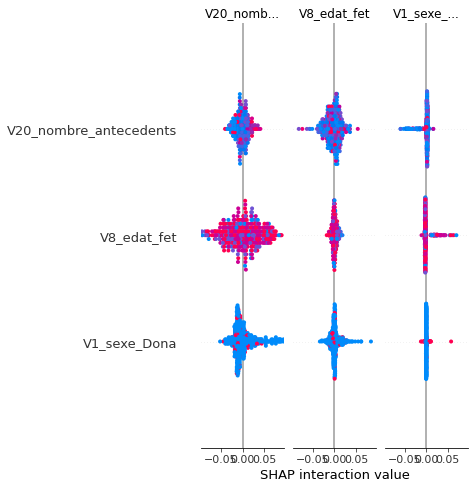

In [132]:
classifier_rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators = 400, criterion = "entropy", random_state = 0))
model = classifier_rfc.fit(train_X, train_y_2)
predALL_y_rfc = classifier_rfc.predict_proba(test_X)
_ = plot_multilabel(test_y_2, predALL_y_rfc)

explainer = shap.Explainer(model.predict_proba, train_X, algorithm = "auto")
shap_values = explainer(train_X)
shap.initjs()
shap.summary_plot(shap_values.values, train_X)

We can see that depends of the model takes takes different importance of the features, but the top5 are equally the same.


# SAVRY

0.11162790697674418


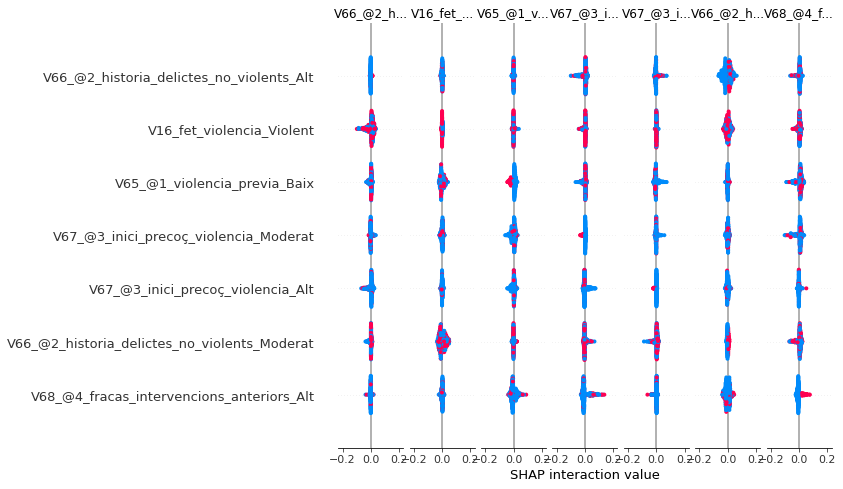

Importance
V68_@4_fracas_intervencions_anteriors_Moderat         0.303171
V67_@3_inici_precoç_violencia_Baix                    0.297483
V65_@1_violencia_previa_Alt                           0.147344
V74_@10_baix_rendiment_escola_Alt                     0.122725
V86_@22_problemes_concentracio_hiperactivitat_Baix    0.075662
V83_@19_problemes_consum_toxics_Moderat              -0.000782
V71_@7_historia_maltracte_infantil_Baix              -0.009768
V15_fet_agrupat_Contra les persones                  -0.012345
V78_@14_escassa_habilitat_pares_educar_Moderat       -0.054890
V73_@9_separacio_precoç_pares_Alt                    -0.058689

In [133]:
train_y_SAVRY = train["V60_SAVRY_total_score"]
test_y_SAVRY = test["V60_SAVRY_total_score"]

LGSavry = LogisticRegression(solver='liblinear')

model = LGSavry.fit(train_X,train_y_SAVRY)

print(LGSavry.score(test_X,test_y_SAVRY))

explainer = shap.Explainer(model.predict_proba, train_X, algorithm = "auto")
shap_values = explainer(train_X)
shap.initjs()
shap.summary_plot(shap_values.values, train_X)
mean = np.mean(LGSavry.coef_, axis=0)
pd.DataFrame(mean*10,index=test_X.columns,columns=["Importance"]).sort_values("Importance",ascending=False)[:10]

The biggest accumulations are important features, but in this model is demography and inici_precoç

# Best model

In [134]:
train_y

0       Sí
1084    No
1116    No
1278    No
82      Sí
        ..
1123    No
1146    No
1114    No
47      Sí
1175    No
Name: V115_reincidencia_2015, Length: 435, dtype: object

In [135]:
test_y

141     Sí
117     Sí
119     Sí
42      Sí
1130    No
        ..
1289    No
1061    No
1037    No
1266    No
1006    No
Name: V115_reincidencia_2015, Length: 215, dtype: object

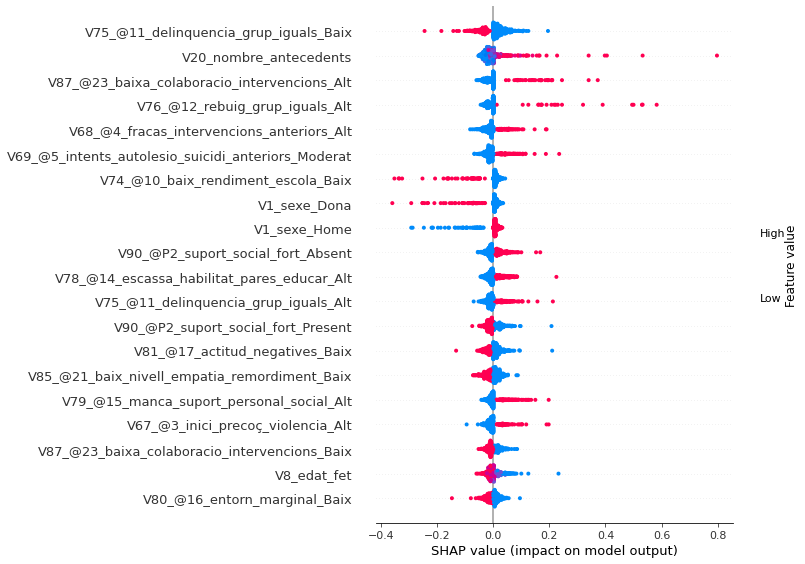

In [136]:
classifier_nb = GaussianNB()
train_y_array = [1 if i == "Sí" else 0 for i in train_y]
test_y_array = [1 if i == "Sí" else 0 for i in test_y]

model = classifier_nb.fit(train_X, train_y_array)
predALL_y_nb = classifier_nb.predict_proba(test_X)[:,1]

explainer = shap.Explainer(model.predict, train_X,algorithm = "auto")
shap_values = explainer(train_X)
shap.initjs()
shap.summary_plot(shap_values, train_X)

The biggest accumulations are important features like sex